In [1]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
from umap import umap_
from sklearn.metrics import silhouette_score
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier


C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/raw/new_retail_data.csv')

---
---

# CLEANING

---

### SELECT DATA

In [3]:
df = df.dropna(subset=['Transaction_ID','Customer_ID'])

In [4]:
df['Transaction_ID'] = df['Transaction_ID'].astype(int)
df['Customer_ID'] = df['Customer_ID'].astype(int)

In [5]:
columns = [
    'Transaction_ID',
    'Customer_ID',
    'State',
    'Country',
    'Age',
    'Gender',
    'Income',
    'Amount',
    'Total_Purchases',
    'Total_Amount',
    'Product_Category',
    'Product_Brand',
    'Product_Type',
    'Shipping_Method',
    'Payment_Method',
    'Ratings']

In [6]:
df_clean = df.copy()[columns]
df_clean = df_clean.dropna()
print(f"Lost {len(df)-len(df_clean)} rows. That is {(len(df)-len(df_clean))/len(df)*100} %")

Lost 3756 rows. That is 1.2463126598953442 %


---
### MAP THE VARIABLES

In [7]:
df_clean['Gender'] = df['Gender'].apply(lambda x: 1 if x=='Male' else 0)

In [8]:
to_replace = {
    'Low' : 1,
    'Medium': 2,
    'High' : 3 
}

df_clean['Income'] = df['Income'].map(to_replace)

---
### DUMMIFY

In [9]:
customer_columns = ['Customer_ID','Age','Gender','Income','State','Country']
transaction_columns = ['Transaction_ID','Customer_ID','Amount','Total_Purchases','Total_Amount','Ratings','Product_Category','Product_Brand','Product_Type','Shipping_Method','Payment_Method']

In [10]:
df_customer = df_clean[customer_columns].drop_duplicates(subset='Customer_ID')
df_transaction = df_clean[transaction_columns]

In [11]:
df_customer = pd.get_dummies(df_customer,columns=['State','Country'], drop_first=True, dtype=int)
df_transaction = pd.get_dummies(df_transaction,columns=['Product_Category','Product_Brand','Product_Type','Shipping_Method','Payment_Method'], drop_first=True, dtype=int)

---
### AGGREGATE TRANSACTIONS

In [12]:
avg_columns = ['Amount', 'Total_Purchases', 'Total_Amount', 'Ratings']
sum_columns = [col for col in df_transaction.columns if col not in avg_columns + ['Customer_ID', 'Transaction_ID']]

agg_dict = {col: 'mean' for col in avg_columns}
agg_dict.update({col: 'sum' for col in sum_columns})


In [13]:
df_aggregated = df_transaction.groupby('Customer_ID').agg(agg_dict).reset_index()

In [14]:
df_aggregated = df_aggregated.merge(df_customer,on='Customer_ID')

---

### SCALING

In [15]:
df_sampled = df_aggregated.sample(n=10000, replace=False, random_state=42)

features = df_sampled.select_dtypes(include=['number']).drop(['Customer_ID'],axis=1)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

---
---
# DIMENSIONAL REDUCTION

In [16]:
# Perform UMAP for dimensionality reduction to 2 dimensions
umap_reducer = umap_.UMAP(n_components=3, random_state=42)
umap_data = umap_reducer.fit_transform(normalized_data)


C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
df_sampled['UMAP1'] = umap_data[:,0]
df_sampled['UMAP2'] = umap_data[:,1]
df_sampled['UMAP3'] = umap_data[:,2]

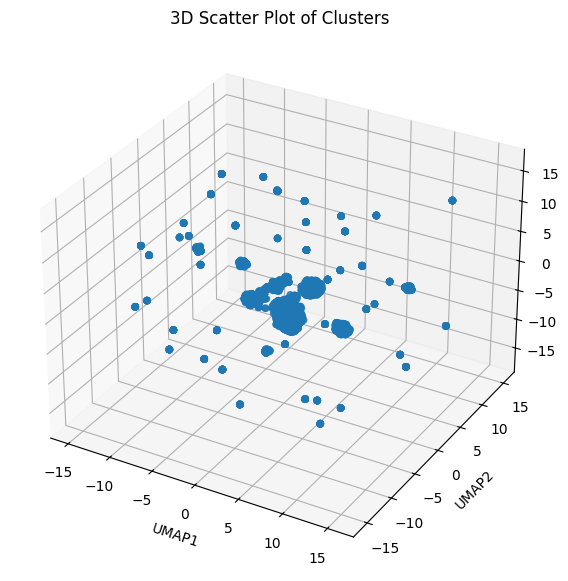

In [18]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  # Replace with your feature if PCA isn't used
y = df_sampled['UMAP2']  # Replace with your feature if PCA isn't used
z = df_sampled['UMAP3']  # Replace with your feature if UMAP isn't used

# Create the scatter plot
scatter = ax.scatter(x, y, z, s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  # Modify as per your dataset

plt.savefig('artifacts/imgs/dimensional_reduction.png')

plt.show()

---
---

# CLUSTERING (no dimensional reduction)

---
### K-means Clustering

In [19]:
kmeans_labels = []
scores = []

for k in range(2,31):

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels += [ kmeans.fit_predict(normalized_data) ]

    labels = kmeans_labels[-1]

    df_sampled['label'] = labels

    kmeans_silhouette = silhouette_score(normalized_data, df_sampled['label'])
    print(f"Silhouette Score for KMeans Clustering with {k} clusters: {kmeans_silhouette:.2f}")

    scores += [kmeans_silhouette]

optimal = np.argmax(scores)+2

print(f"the optimal number of clusters is {optimal}, with a score of {scores[optimal-2]:.2f}")

Silhouette Score for KMeans Clustering with 2 clusters: 0.42
Silhouette Score for KMeans Clustering with 3 clusters: 0.04
Silhouette Score for KMeans Clustering with 4 clusters: 0.03
Silhouette Score for KMeans Clustering with 5 clusters: 0.04
Silhouette Score for KMeans Clustering with 6 clusters: -0.03
Silhouette Score for KMeans Clustering with 7 clusters: -0.02
Silhouette Score for KMeans Clustering with 8 clusters: 0.02
Silhouette Score for KMeans Clustering with 9 clusters: 0.02
Silhouette Score for KMeans Clustering with 10 clusters: 0.00
Silhouette Score for KMeans Clustering with 11 clusters: 0.01
Silhouette Score for KMeans Clustering with 12 clusters: 0.01
Silhouette Score for KMeans Clustering with 13 clusters: 0.01
Silhouette Score for KMeans Clustering with 14 clusters: 0.01
Silhouette Score for KMeans Clustering with 15 clusters: 0.00
Silhouette Score for KMeans Clustering with 16 clusters: 0.00
Silhouette Score for KMeans Clustering with 17 clusters: 0.01
Silhouette Sco

In [20]:
# Assign K-means cluster labels to the DataFrame
df_sampled['KMeans_Cluster'] = kmeans_labels[optimal-2]

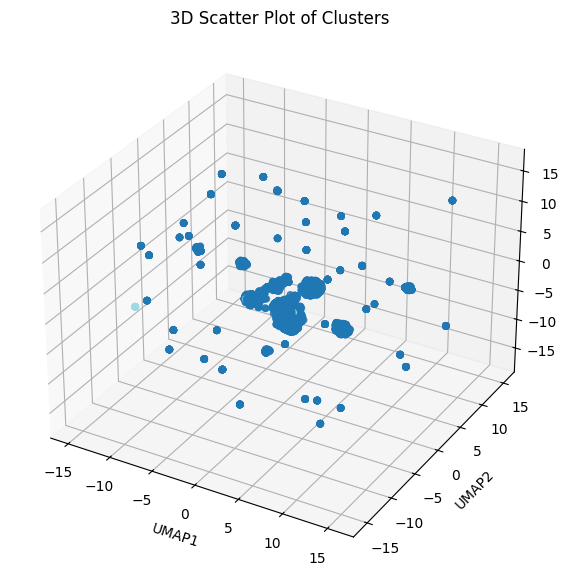

In [21]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  # Replace with your feature if PCA isn't used
y = df_sampled['UMAP2']  # Replace with your feature if PCA isn't used
z = df_sampled['UMAP3']  # Replace with your feature if UMAP isn't used
labels = df_sampled['KMeans_Cluster']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  # Modify as per your dataset

plt.savefig('artifacts/imgs/clustering_KMEANS_noDimensionalReduction.png')

plt.show()


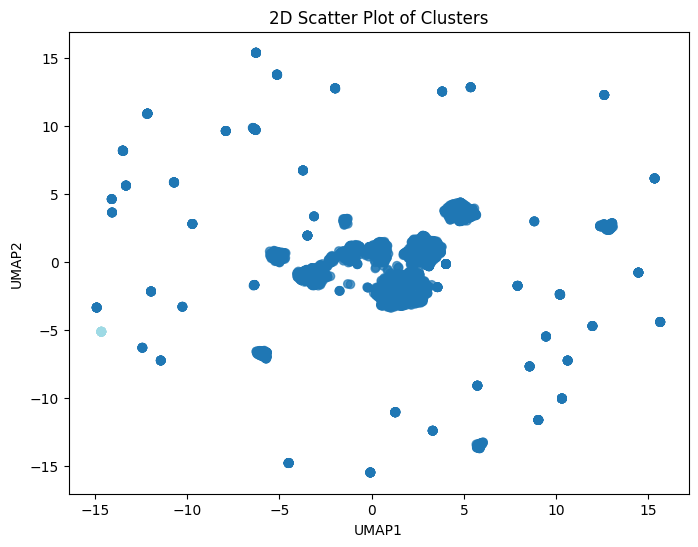

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['KMeans_Cluster'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


---
---

# CLUSTERING (*with* dimensional reduction)

---
### K-means Clustering

In [23]:
scores = []
kmeans_labels = []


for k in range(2,101):

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels += [ kmeans.fit_predict(df_sampled[['UMAP1','UMAP2','UMAP3']]) ]

    labels = kmeans_labels[-1]

    df_sampled['label'] = labels

    kmeans_silhouette = silhouette_score(df_sampled[['UMAP1','UMAP2','UMAP3']], df_sampled['label'])
    print(f"Silhouette Score for KMeans Clustering with {k} clusters: {kmeans_silhouette:.2f}")

    scores += [kmeans_silhouette]

optimal = np.argmax(scores)+2

print(f"the optimal number of clusters is {optimal}, with a score of {scores[optimal-2]:.2f}")

Silhouette Score for KMeans Clustering with 2 clusters: 0.49
Silhouette Score for KMeans Clustering with 3 clusters: 0.34
Silhouette Score for KMeans Clustering with 4 clusters: 0.43
Silhouette Score for KMeans Clustering with 5 clusters: 0.45
Silhouette Score for KMeans Clustering with 6 clusters: 0.42
Silhouette Score for KMeans Clustering with 7 clusters: 0.48
Silhouette Score for KMeans Clustering with 8 clusters: 0.53
Silhouette Score for KMeans Clustering with 9 clusters: 0.47
Silhouette Score for KMeans Clustering with 10 clusters: 0.48
Silhouette Score for KMeans Clustering with 11 clusters: 0.52
Silhouette Score for KMeans Clustering with 12 clusters: 0.54
Silhouette Score for KMeans Clustering with 13 clusters: 0.54
Silhouette Score for KMeans Clustering with 14 clusters: 0.55
Silhouette Score for KMeans Clustering with 15 clusters: 0.57
Silhouette Score for KMeans Clustering with 16 clusters: 0.61
Silhouette Score for KMeans Clustering with 17 clusters: 0.62
Silhouette Score

In [24]:
# Assign K-means cluster labels to the DataFrame
df_sampled['KMeans_Cluster_UMAP'] = kmeans_labels[optimal - 2]


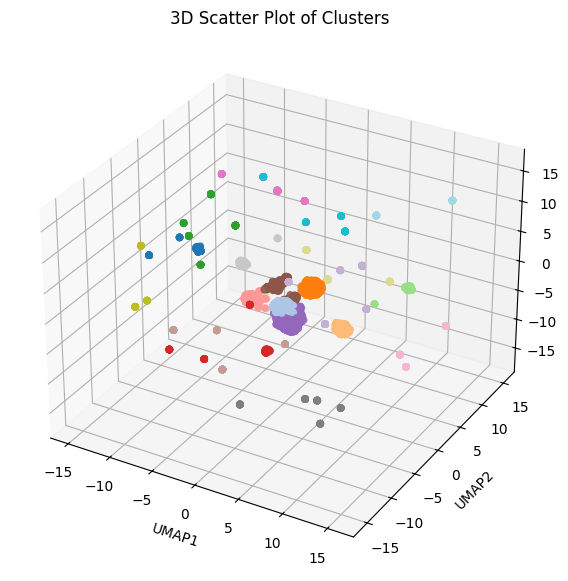

In [25]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  # Replace with your feature if PCA isn't used
y = df_sampled['UMAP2']  # Replace with your feature if PCA isn't used
z = df_sampled['UMAP3']  # Replace with your feature if UMAP isn't used
labels = df_sampled['KMeans_Cluster_UMAP']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  # Modify as per your dataset

plt.savefig('artifacts/imgs/clustering_KMEANS_dimensionalReduction.png')

plt.show()


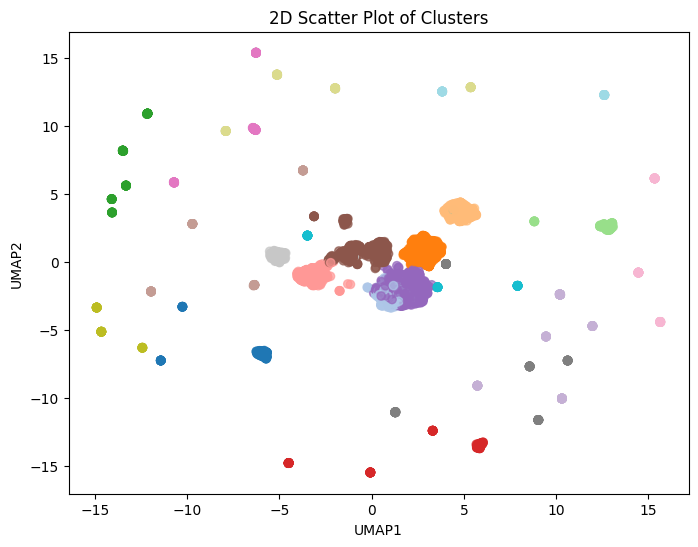

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['KMeans_Cluster_UMAP'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


---

# HIERARCHICAL

In [27]:
hierarchical_labels = []
scores = []

data_to_cluster = df_sampled[['UMAP1', 'UMAP2', 'UMAP3']]

for k in range(2,101):

    hierarchical = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    hierarchical_labels += [hierarchical.fit_predict(data_to_cluster)]

    labels = hierarchical_labels[-1]

    df_sampled['label'] = labels

    silhouette = silhouette_score(df_sampled[['UMAP1','UMAP2','UMAP3']], df_sampled['label'])
    print(f"Silhouette Score for Hierarchical Clustering with {k} clusters: {silhouette:.2f}")

    scores += [silhouette]

optimal = np.argmax(scores)+2

print(f"the optimal number of clusters is {optimal}, with a score of {scores[optimal-2]:.2f}")


Silhouette Score for Hierarchical Clustering with 2 clusters: 0.27
Silhouette Score for Hierarchical Clustering with 3 clusters: 0.36
Silhouette Score for Hierarchical Clustering with 4 clusters: 0.40
Silhouette Score for Hierarchical Clustering with 5 clusters: 0.39
Silhouette Score for Hierarchical Clustering with 6 clusters: 0.43
Silhouette Score for Hierarchical Clustering with 7 clusters: 0.45
Silhouette Score for Hierarchical Clustering with 8 clusters: 0.51
Silhouette Score for Hierarchical Clustering with 9 clusters: 0.53
Silhouette Score for Hierarchical Clustering with 10 clusters: 0.54
Silhouette Score for Hierarchical Clustering with 11 clusters: 0.57
Silhouette Score for Hierarchical Clustering with 12 clusters: 0.58
Silhouette Score for Hierarchical Clustering with 13 clusters: 0.61
Silhouette Score for Hierarchical Clustering with 14 clusters: 0.61
Silhouette Score for Hierarchical Clustering with 15 clusters: 0.62
Silhouette Score for Hierarchical Clustering with 16 clu

In [28]:
df_sampled['Hierarchical_Cluster_UMAP'] = hierarchical_labels[optimal - 2]


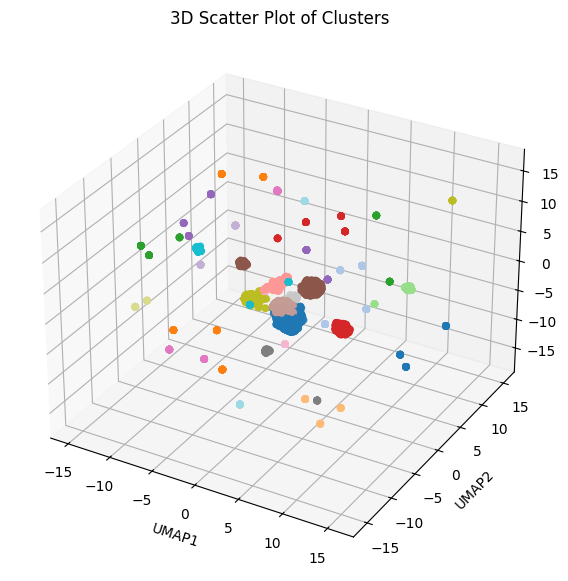

In [29]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  # Replace with your feature if PCA isn't used
y = df_sampled['UMAP2']  # Replace with your feature if PCA isn't used
z = df_sampled['UMAP3']  # Replace with your feature if UMAP isn't used
labels = df_sampled['Hierarchical_Cluster_UMAP']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  # Modify as per your dataset

plt.savefig('artifacts/imgs/clustering_hierarchical_dimensionalReduction.png')

plt.show()

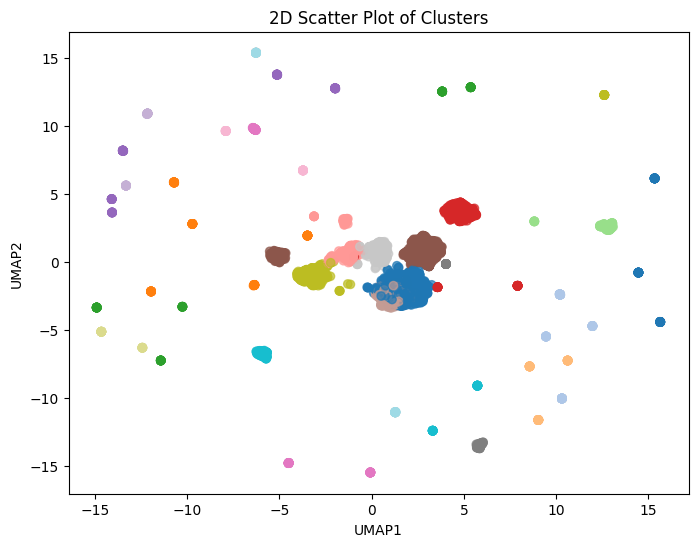

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['Hierarchical_Cluster_UMAP'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

---

# DBSCAN

In [31]:
dbscan_labels = []
scores = []

data_to_cluster = df_sampled[['UMAP1', 'UMAP2', 'UMAP3']]

for scale in np.linspace(0.1,5,100)[::-1]:

    dbscan = DBSCAN(eps=scale, min_samples=10)  # Adjust eps and min_samples as needed
    dbscan_labels += [dbscan.fit_predict(data_to_cluster)]

    labels = dbscan_labels[-1]

    df_sampled['label'] = labels

    k = len(df_sampled['label'].unique())

    silhouette = silhouette_score(df_sampled[['UMAP1','UMAP2','UMAP3']], df_sampled['label'])
    print(f"Silhouette Score for DBSCAN Clustering with {k} clusters (eps = {scale:.2f}): {silhouette:.2f}")

    scores += [silhouette]

optimal = np.argmax(scores)

df_sampled['DBSCAN_Cluster_UMAP'] = dbscan_labels[optimal]
k = len(df_sampled['DBSCAN_Cluster_UMAP'].unique())

print(f"the optimal number of clusters is {k}, with a score of {scores[optimal]:.2f}")


Silhouette Score for DBSCAN Clustering with 39 clusters (eps = 5.00): 0.60
Silhouette Score for DBSCAN Clustering with 39 clusters (eps = 4.95): 0.60
Silhouette Score for DBSCAN Clustering with 39 clusters (eps = 4.90): 0.60
Silhouette Score for DBSCAN Clustering with 39 clusters (eps = 4.85): 0.60
Silhouette Score for DBSCAN Clustering with 39 clusters (eps = 4.80): 0.60
Silhouette Score for DBSCAN Clustering with 40 clusters (eps = 4.75): 0.60
Silhouette Score for DBSCAN Clustering with 40 clusters (eps = 4.70): 0.60
Silhouette Score for DBSCAN Clustering with 41 clusters (eps = 4.65): 0.60
Silhouette Score for DBSCAN Clustering with 41 clusters (eps = 4.60): 0.60
Silhouette Score for DBSCAN Clustering with 42 clusters (eps = 4.55): 0.60
Silhouette Score for DBSCAN Clustering with 43 clusters (eps = 4.51): 0.60
Silhouette Score for DBSCAN Clustering with 43 clusters (eps = 4.46): 0.60
Silhouette Score for DBSCAN Clustering with 43 clusters (eps = 4.41): 0.60
Silhouette Score for DBSC

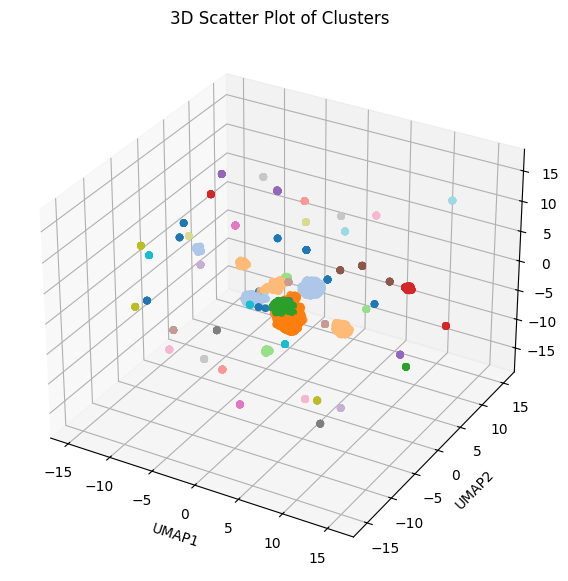

In [32]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  # Replace with your feature if PCA isn't used
y = df_sampled['UMAP2']  # Replace with your feature if PCA isn't used
z = df_sampled['UMAP3']  # Replace with your feature if UMAP isn't used
labels = df_sampled['DBSCAN_Cluster_UMAP']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  # Modify as per your dataset

plt.savefig('artifacts/imgs/clustering_DBSCAN_dimensionalReduction.png')

plt.show()

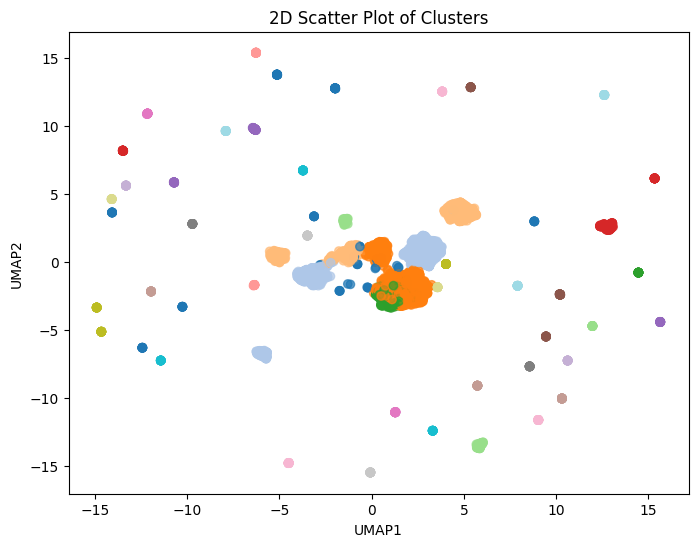

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['DBSCAN_Cluster_UMAP'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

---

### GAUSSIAN MIXTURES

In [34]:
gaussian_labels = []
scores = []

data_to_cluster = df_sampled[['UMAP1', 'UMAP2', 'UMAP3']]


for k in range(2,101):

    gmm = GaussianMixture(n_components=k, random_state=42)  # Adjust n_components as needed
    gaussian_labels += [gmm.fit_predict(data_to_cluster)]

    labels = gaussian_labels[-1]

    df_sampled['label'] = labels

    silhouette = silhouette_score(df_sampled[['UMAP1','UMAP2','UMAP3']], df_sampled['label'])
    print(f"Silhouette Score for Gaussian Mixures with {k} gaussians: {silhouette:.2f}")

    scores += [silhouette]

optimal = np.argmax(scores)+2

print(f"the optimal number of clusters is {optimal}, with a score of {scores[optimal-2]:.2f}")

Silhouette Score for Gaussian Mixures with 2 gaussians: 0.54
Silhouette Score for Gaussian Mixures with 3 gaussians: 0.46
Silhouette Score for Gaussian Mixures with 4 gaussians: 0.31
Silhouette Score for Gaussian Mixures with 5 gaussians: 0.32
Silhouette Score for Gaussian Mixures with 6 gaussians: 0.40
Silhouette Score for Gaussian Mixures with 7 gaussians: 0.42
Silhouette Score for Gaussian Mixures with 8 gaussians: 0.52
Silhouette Score for Gaussian Mixures with 9 gaussians: 0.48
Silhouette Score for Gaussian Mixures with 10 gaussians: 0.49
Silhouette Score for Gaussian Mixures with 11 gaussians: 0.54
Silhouette Score for Gaussian Mixures with 12 gaussians: 0.55
Silhouette Score for Gaussian Mixures with 13 gaussians: 0.55
Silhouette Score for Gaussian Mixures with 14 gaussians: 0.56
Silhouette Score for Gaussian Mixures with 15 gaussians: 0.57
Silhouette Score for Gaussian Mixures with 16 gaussians: 0.61
Silhouette Score for Gaussian Mixures with 17 gaussians: 0.62
Silhouette Score

In [35]:
df_sampled['Gaussian_Cluster_UMAP'] = gaussian_labels[optimal - 2]


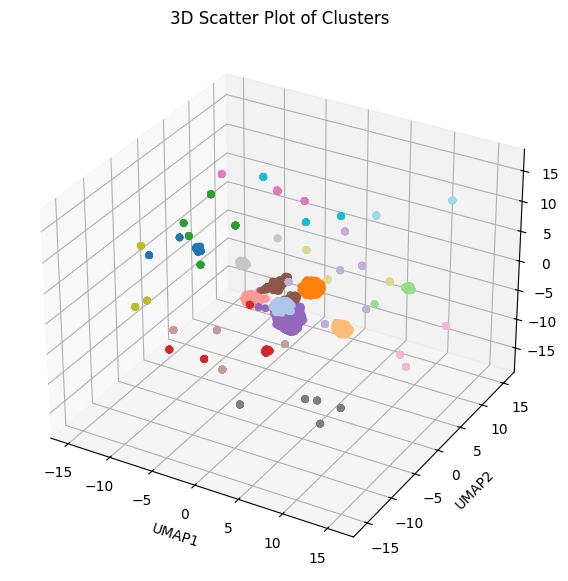

In [36]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  # Replace with your feature if PCA isn't used
y = df_sampled['UMAP2']  # Replace with your feature if PCA isn't used
z = df_sampled['UMAP3']  # Replace with your feature if UMAP isn't used
labels = df_sampled['Gaussian_Cluster_UMAP']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  # Modify as per your dataset

plt.savefig('artifacts/imgs/clustering_gaussian_dimensionalReduction.png')

plt.show()

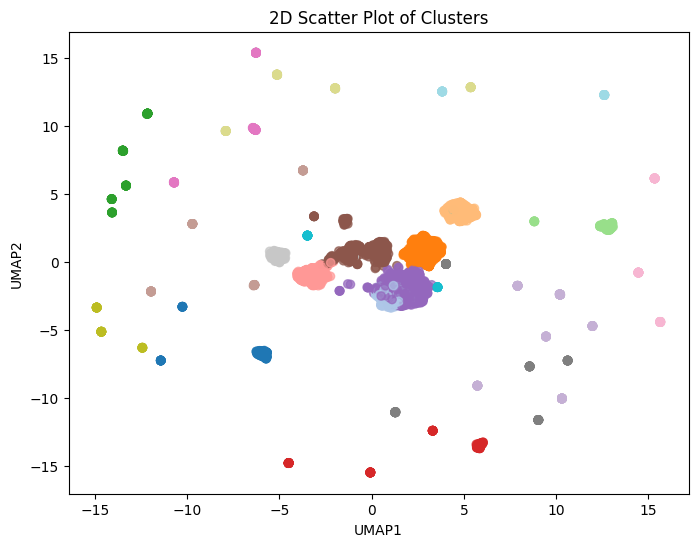

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['Gaussian_Cluster_UMAP'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

---

### CUSTOMER SEGMENT

In [38]:
df_sampled

,Customer_ID,Amount,Total_Purchases,Total_Amount,Ratings,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Grocery,Product_Category_Home Decor,Product_Brand_Apple,...,Country_USA,UMAP1,UMAP2,UMAP3,label,KMeans_Cluster,KMeans_Cluster_UMAP,Hierarchical_Cluster_UMAP,DBSCAN_Cluster_UMAP,Gaussian_Cluster_UMAP
27836,38916,308.117176,7.500000,2025.116317,2.500000,1,0,0,1,0,...,1,-1.977722,12.745166,-7.876957,14,0,17,12,0,17
30045,41207,59.791135,1.000000,59.791135,2.000000,0,1,0,0,1,...,1,-5.123384,13.747624,-4.694497,57,0,17,12,1,17
51246,63231,210.829109,4.200000,1076.561562,4.000000,0,1,1,2,0,...,0,-6.094432,-6.742931,9.308510,0,0,0,27,2,0
41902,53551,276.961245,4.500000,1083.382264,3.000000,0,2,1,1,0,...,1,-3.511250,-0.705117,-2.212847,77,0,7,25,3,7
15466,26092,427.408275,6.333333,2780.969075,2.000000,0,0,0,1,0,...,0,2.980423,1.051563,2.063421,73,0,2,15,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60218,72580,139.515757,2.000000,279.031515,4.500000,1,1,0,0,0,...,0,3.374911,0.622584,0.449882,25,0,2,15,4,2
19413,30181,238.938035,6.000000,1344.270422,3.500000,0,0,2,2,0,...,0,2.245903,0.677259,1.904289,60,0,2,15,4,2
82710,95963,279.844231,5.000000,1404.384927,3.333333,0,2,1,0,0,...,0,-0.004522,1.075488,-2.109494,95,0,10,23,5,10
63418,75906,117.262100,9.000000,1107.936239,4.333333,0,0,1,1,0,...,1,-3.129446,-1.015666,-1.997161,94,0,7,25,3,7


In [39]:
df_sampled = df_sampled.merge(df[['Customer_ID','Customer_Segment']].drop_duplicates(subset=['Customer_ID']),on='Customer_ID',how='left')

In [40]:
to_replace = {
    'Regular' : 2,
    'Premium' : 3,
    'New' : 1
}

df_sampled['Customer_Segment_encoded'] = df_sampled['Customer_Segment'].map(to_replace)
df_sampled['Customer_Segment_encoded'] = df_sampled['Customer_Segment_encoded'].fillna(0)


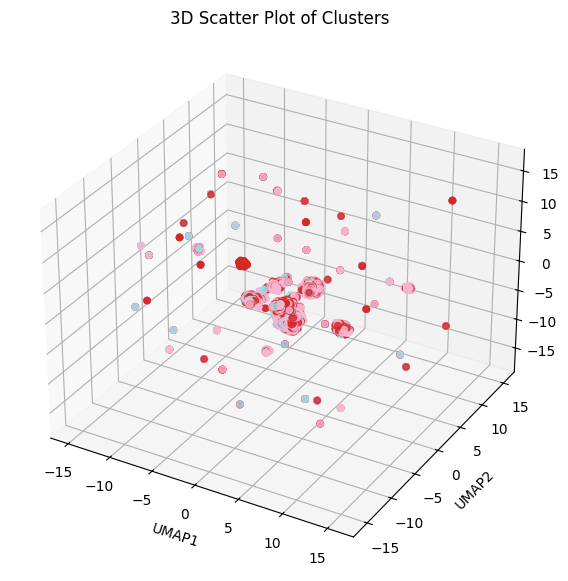

In [41]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  # Replace with your feature if PCA isn't used
y = df_sampled['UMAP2']  # Replace with your feature if PCA isn't used
z = df_sampled['UMAP3']  # Replace with your feature if UMAP isn't used
labels = df_sampled['Customer_Segment_encoded']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

plt.savefig('artifacts/imgs/clustering_customerSegments.png')

plt.show()


---
---

# RECONCILE SAMPLED WITH THE WHOLE DATASET

In [42]:
df_aggregated = df_aggregated.merge(df_sampled[['Customer_ID','DBSCAN_Cluster_UMAP']],on='Customer_ID',how='left')
df_aggregated = df_aggregated.merge(df[['Customer_ID','Customer_Segment']].drop_duplicates(subset=['Customer_ID']),on='Customer_ID',how='left')

In [43]:
features = df_aggregated.select_dtypes(include=['number']).drop(['Customer_ID','DBSCAN_Cluster_UMAP'],axis=1)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

In [44]:
umap_reducer = umap_.UMAP(n_components=3, random_state=42)
umap_data = umap_reducer.fit_transform(normalized_data)

df_aggregated['UMAP1'] = umap_data[:,0]
df_aggregated['UMAP2'] = umap_data[:,1]
df_aggregated['UMAP3'] = umap_data[:,2]

C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


---

### KNN IMPUTATION

In [45]:
df_aggregated['Cluster'] = df_aggregated['DBSCAN_Cluster_UMAP']

# Identify rows with and without missing labels
train_data = df_aggregated[df_aggregated['DBSCAN_Cluster_UMAP'].notnull()]
test_data = df_aggregated[df_aggregated['DBSCAN_Cluster_UMAP'].isnull()]

# Features and labels for training
X_train = train_data[['UMAP1', 'UMAP2','UMAP3']].values
y_train = train_data['DBSCAN_Cluster_UMAP'].values

# Features for prediction
X_test = test_data[['UMAP1', 'UMAP2', 'UMAP3']].values

# Fit the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict the missing labels
if len(X_test) > 0:  # Ensure there are missing labels to predict
    y_pred = knn.predict(X_test)

    # Assign predicted labels to the test data
    df_aggregated.loc[df_aggregated['DBSCAN_Cluster_UMAP'].isnull(), 'Cluster'] = y_pred


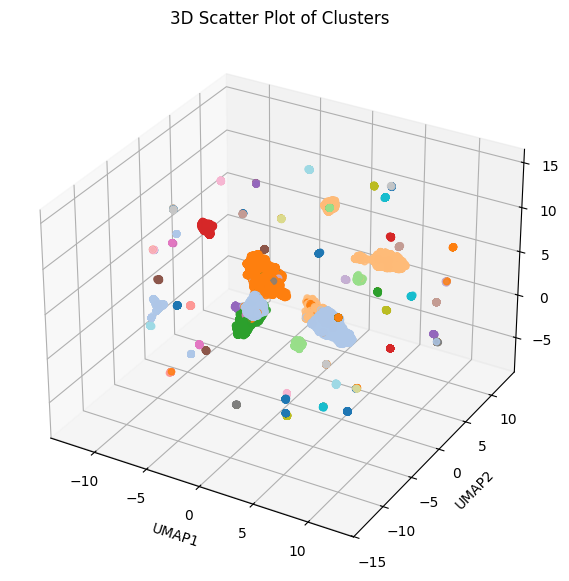

In [46]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_aggregated['UMAP1']  # Replace with your feature if PCA isn't used
y = df_aggregated['UMAP2']  # Replace with your feature if PCA isn't used
z = df_aggregated['UMAP3']  # Replace with your feature if UMAP isn't used
labels = df_aggregated['Cluster']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

plt.savefig('artifacts/imgs/clustering.png')

plt.show()

---

### UNDUMMIFY

In [47]:
df_customer = df_clean[customer_columns].drop_duplicates(subset='Customer_ID')
df_transaction = df_clean[transaction_columns]

In [48]:
df_transaction = pd.get_dummies(df_transaction,columns=['Product_Category','Product_Brand','Product_Type','Shipping_Method','Payment_Method'], drop_first=False, dtype=int)

In [49]:
df_aggregated_ = df_transaction.groupby('Customer_ID').agg(agg_dict).reset_index()
df_aggregated_ = df_aggregated_.merge(df_customer,on='Customer_ID')

In [50]:
df_aggregated_ = df_aggregated_.merge(df_aggregated[['Customer_ID','Cluster','UMAP1','UMAP2','UMAP3']],on='Customer_ID')

In [51]:
# Save the DataFrame with the new column
df_aggregated_.to_csv('data/processed/new_retail_customer_clustering.csv', index=False)

print("Imputation completed and saved to 'new_retail_customer_clustering.csv'")


Imputation completed and saved to 'new_retail_customer_clustering.csv'
